In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

C:\Users\hakos\AppData\Local\Temp\ipykernel_20544\1186495989.py:1: DtypeWarning: Columns (6,8,9,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)


0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4187    2022-08-31
4188    2022-09-30
4189    2022-10-31
4190    2022-11-30
4191    2022-12-31
Name: ship_date, Length: 4192, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4187    0
4188    0
4189    0
4190    0
4191    0
Name: mon_1, Length: 4192, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1420 entries, (114, Timestamp('2009-11-30 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 641 entries, year to year_trend
dtypes: float64(14), int32(3), int64(602), object(10), uint8(12)
memory usage: 6.8+ MB


(641, 167, 18)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [7]:
before_p=10*12
after_p=15*12
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m120+elapsed_m119+elapsed_m118+elapsed_m117+elapsed_m116+elapsed_m115+elapsed_m114+elapsed_m113+elapsed_m112+elapsed_m111+elapsed_m110+elapsed_m109+elapsed_m108+elapsed_m107+elapsed_m106+elapsed_m105+elapsed_m104+elapsed_m103+elapsed_m102+elapsed_m101+elapsed_m100+elapsed_m99+elapsed_m98+elapsed_m97+elapsed_m96+elapsed_m95+elapsed_m94+elapsed_m93+elapsed_m92+elapsed_m91+elapsed_m90+elapsed_m89+elapsed_m88+elapsed_m87+elapsed_m86+elapsed_m85+elapsed_m84+elapsed_m83+elapsed_m82+elapsed_m81+elapsed_m80+elapsed_m79+elapsed_m78+elapsed_m77+elapsed_m76+elapsed_m75+elapsed_m74+elapsed_m73+elapsed_m72+elapsed_m71+elapsed_m70+elapsed_m69+elapsed_m68+elapsed_m67+elapsed_m66+elapsed_m65+elapsed_m64+elapsed_m63+elapsed_m62+elapsed_m61+elapsed_m60+elapsed_m59+elapsed_m58+elapsed_m57+elapsed_m56+elapsed_m55+elapsed_m54+elapsed_m53+elapsed_m52+elapsed_m51+elapsed_m50+elapsed_m49+elapsed_m48+elapsed_m47+elapsed_m46+elapsed_m45+elapsed_m44+elapsed_m43+elapsed_m42+elapsed_m41+elapsed_m40+elapse

## RX

C:\Users\hakos\AppData\Local\Temp\ipykernel_20544\385983036.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

mon_2, mon_3, mon_4, mon_5, mon_6, mon_7, mon_8, mon_9, mon_10, mon_11, mon_12

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m120       -0.1902     0.1716    -1.1085     0.2679     -0.5269      0.1465
elapsed_m119       -0.3127     0.1140    -2.7436     0.0062     -0.5365     -0.0890
elapsed_m118       -0.6023     0.2815    -2.1396     0.0326     -1.1547     -0.0498
elapsed_m117       -0.3891     0.1732    -2.2470     0.0249     -0.7289     -0.0493
elapsed_m116       -0.2659     0.1687    -1.5760     0.1154     -0.5970      0.0652
elapsed_m115       -0.5003     0.2305    -2.1704     0.0302     -0.9527     -0.0479
elapsed_m114       -0.7783     0.2101    -3.7052     0.0002     -1.1906     -0.3661
elapsed_m113        0.2033     0.3007     0.6762     0.4991     -0.3868      0.7934
elapsed_m112       -0.2862     0.2358    -1.2137     0.2252     -0.7489     

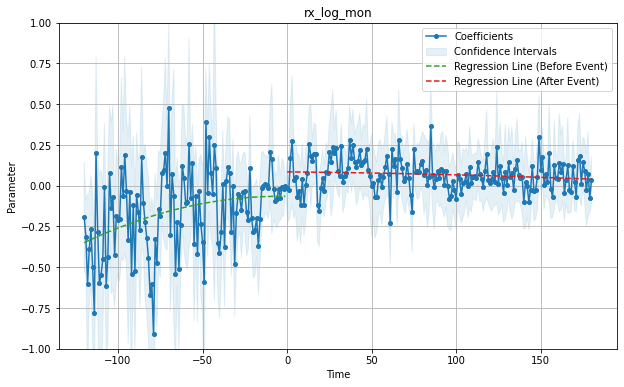

In [8]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="rx_log_mon",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m120       -0.6127     0.8822    -0.6944     0.4876     -2.3441      1.1188
elapsed_m119       -0.1347     0.9315    -0.1446     0.8851     -1.9629      1.6935
elapsed_m118       -0.3081     0.4097    -0.7520     0.4523     -1.1122      0.4960
elapsed_m117       -1.0264     0.8888    -1.1547     0.2485     -2.7707      0.7180
elapsed_m116        1.2878     0.6856     1.8783     0.0607     -0.0577      2.6333
elapsed_m115       -1.8491     0.6427    -2.8769     0.0041     -3.1105     -0.5877
elapsed_m114        1.6141     0.8671     1.8615     0.0630     -0.0876      3.3157
elapsed_m113        1.7222     1.0344     1.6649     0.0963     -0.3078      3.7522
elapsed_m112       -0.1467     0.8283    -0.1771     0.8595     -1.7723     

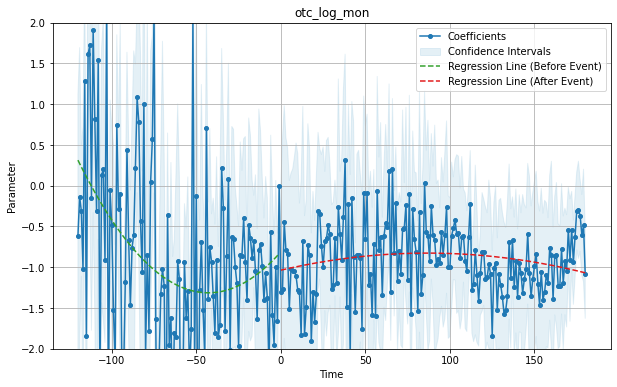

In [9]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="otc_log_mon",ylim=(-2,2),plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)